# Load data

In [13]:
import os
import pandas as pd

import pickle
from collections import Counter
from tqdm import tqdm
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid", palette="deep")
from _00_text_utils import title_process, process_quoting, comment_process, selftext_process

In [2]:
df = pd.read_csv(f'{os.getcwd()}/data/data_active_authorExt.tsv', sep='\t')

## Determine which authors to fine-tune for baseline

In [3]:
author_cnt = Counter()
author_cnt.update(df.commAuthor.tolist())
author_cnt = sorted(author_cnt.items(), key=lambda x:x[1], reverse=True)

In [4]:
j, thr_list = 0, [2000, 1000, 500, 200, 100]
for i, elem in enumerate(author_cnt):
    if elem[1] <= thr_list[j]:
        print(f"{i} authors commented more than {thr_list[j]}")
        j += 1
    if j >= len(thr_list):
        break

6 authors commented more than 2000
8 authors commented more than 1000
9 authors commented more than 500
46 authors commented more than 200
219 authors commented more than 100


In [5]:
author_cnt[0], author_cnt[99], author_cnt[-1]

(('iluvcats17', 2863), ('Annual-Contract-115', 138), ('nebunala4328', 100))

In [6]:
AUTHORS = [elem[0] for elem in author_cnt[:100]]

# Read output file

In [7]:
all_output_lines = []
with open(f"{os.getcwd()}/console_outputs/clf-roberta-selftext-overall.txt", "r") as file:
    for line in file:
        all_output_lines.append(line)

In [11]:
fold_indices = []
for i in range(5):
    for idx,elem in enumerate(all_output_lines):
        if "===fold"+str(i)+"===" in elem:
            fold_indices.append(idx)

In [13]:
author_indices = {}
for idx,elem in enumerate(all_output_lines):
    if elem.startswith("[AUTHOR] "):
        _author = elem.replace("[AUTHOR]","").strip()
        if _author not in author_indices:
            author_indices[_author] = [idx]
        else:
            author_indices[_author].append(idx)

In [32]:
author_to_macrof1 = {_author:[] for _author in author_indices}

for _author in author_indices:
    for item in author_indices[_author]:
        # print(item)
        for idx,elem in enumerate(all_output_lines[item:]):
            if 'macro avg' in elem:
                author_to_macrof1[_author].append(float(elem.split()[4]))
                break

In [41]:
author_to_dist = {_author:[] for _author in AUTHORS}
author_to_size = {_author:[] for _author in AUTHORS}
for _author in AUTHORS:
    minidf = df[df['commAuthor']==_author]
    minidf_trainvalid = minidf.sample(frac=0.7, replace=False, random_state=2024)
    minidf_test = minidf[~minidf.index.isin(minidf_trainvalid.index)]
    
    test_judgments = minidf_test['judgment'].tolist()
    test_distribution = sum(test_judgments)/len(test_judgments)
    author_to_dist[_author] = test_distribution
    author_to_size[_author] = len(minidf)

### visualize author's judgment distributions

In [7]:
minidf = df[df['commAuthor'].isin(AUTHORS)]
author_to_judgments = {_author:[] for _author in AUTHORS}
for idx, row in minidf.iterrows():
    author_to_judgments[row['commAuthor']].append(row['judgment'])

author_to_judgment_dist = {_author:sum(author_to_judgments[_author])/len(author_to_judgments[_author]) for _author in AUTHORS}

In [8]:
author_to_judgment_dist_tup = author_to_judgment_dist.items()
df_viz = pd.DataFrame(data={'authors':[elem[0] for elem in author_to_judgment_dist_tup], 'dists':[elem[1] for elem in author_to_judgment_dist_tup]})

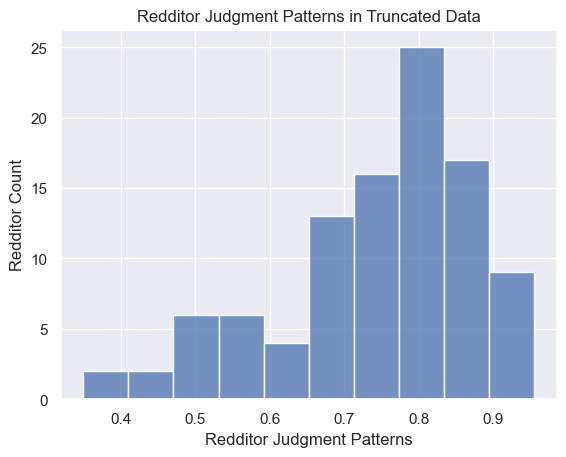

<Axes: title={'center': 'Redditor Judgment Patterns in Truncated Data'}, xlabel='Redditor Judgment Patterns', ylabel='Redditor Count'>

In [16]:
g = sns.histplot(data=df_viz, x="dists")
plt.title('Redditor Judgment Patterns in Truncated Data')
plt.xlabel('Redditor Judgment Patterns')
plt.ylabel('Redditor Count')
# plt.legend(title='Embedding Set')
# plt.grid(True)
plt.show()
g

In [17]:
g.figure.savefig(f'{os.getcwd()}/diagram/truncated_judgment_patterns.png', bbox_inches='tight')

In [32]:
author_to_judgment_dist_s = sorted(author_to_judgment_dist.items(), key=lambda x:x[1])

## visualize performance w.r.t. size/distribution 

<Axes: xlabel='dists', ylabel='f1'>

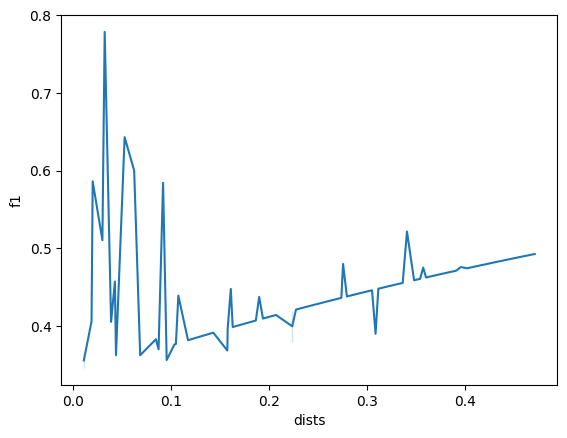

In [42]:
datadict = { 'f1':[], 'dists':[], }
for _author in AUTHORS:
    avg_f1 = np.mean(author_to_macrof1[_author])
    
    datadict['f1'].append(avg_f1)
    datadict['dists'].append(abs(author_to_dist[_author]-0.5))
df_viz = pd.DataFrame(data=datadict)

sns.lineplot(
    data=df_viz, x="dists", y="f1",
)

<Axes: xlabel='size', ylabel='f1'>

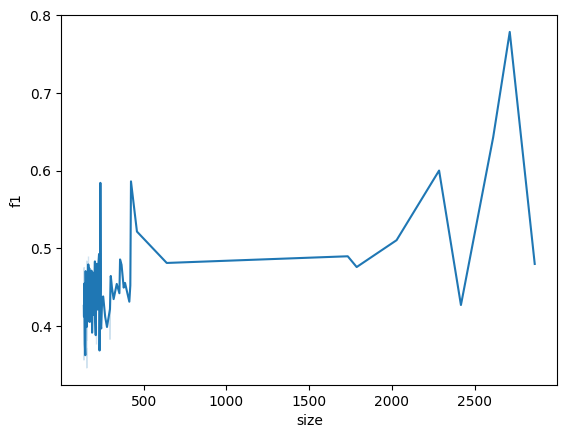

In [40]:
datadict = { 'f1':[], 'size':[], }
for _author in AUTHORS:
    avg_f1 = np.mean(author_to_macrof1[_author])
    
    datadict['f1'].append(avg_f1)
    datadict['size'].append(author_to_size[_author])
df_viz = pd.DataFrame(data=datadict)

sns.lineplot(
    data=df_viz, x="size", y="f1",
)

<Axes: xlabel='size_dists', ylabel='f1'>

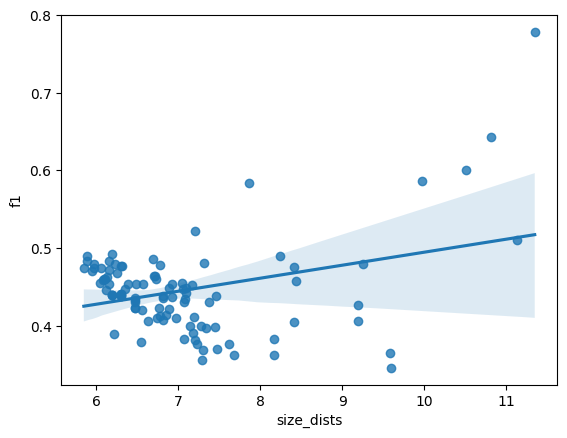

In [52]:
datadict = { 'f1':[], 'size_dists':[], }
# hypothesis: as dists larger and size smaller, performance lowers
for _author in AUTHORS:
    avg_f1 = np.mean(author_to_macrof1[_author])
    
    datadict['f1'].append(avg_f1)
    datadict['size_dists'].append(np.log(author_to_size[_author]/abs(0.5-author_to_dist[_author])))
df_viz = pd.DataFrame(data=datadict)

sns.regplot(
    data=df_viz, x="size_dists", y="f1",
)

In [53]:
with open(f"{os.getcwd()}/outputs/distilbert-base-uncased_author_results_hard.pkl", "rb") as f:
    author_results_hard = pickle.load(f)